(Source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

# Data Set Information: #

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link]

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)



In [8]:
from sklearn.datasets import load_breast_cancer
import numpy as np

In [9]:
bc = load_breast_cancer()
X = bc.data
y = bc.target

X.shape, y.shape

((569, 30), (569,))

In [10]:
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler(copy=False)
ssc.fit_transform(X)

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

np.sum(pca.explained_variance_ratio_)

0.9515688143331487

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

### Logistic Regression Classifier ###

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

sc_log_reg = log_reg.score(X_test, y_test)
p_test_log_reg = log_reg.predict_proba(X_test)
y_pred_log_reg = np.argmax(p_test_log_reg, axis=1)

print(f"sc_log_reg: {sc_log_reg}")

sc_log_reg: 0.9736842105263158


### Suport Vector Classifier ###

In [30]:
from sklearn import svm

svm_clf = svm.SVC(probability=True)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

## Determine precision and recall ##
<br>
Recall is, of course, the more important metric here, since not recognizing cancer in a patient who has cancer (i.e. classifing him falsely as negative) is worse than classifing a patient who does not have cancer as someone who has (false positive) - because in this case further test would be undertaken and the error would most probably be discovered before some serious measures would (falsely) be undertaken.

Recall for logistic-regression: 1.000
Precision for logistic-regression:: 0.958


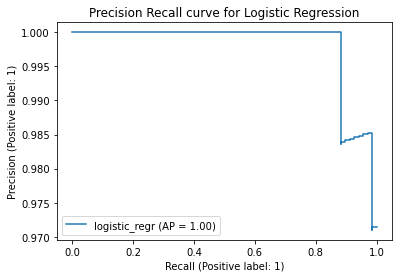

In [31]:
from sklearn.metrics import recall_score, precision_score, PrecisionRecallDisplay

recall_log_reg = recall_score(y_true=y_test, y_pred=y_pred_log_reg)
print(f"Recall for logistic-regression: {recall_log_reg:.3f}")
precision_log_reg = precision_score(y_true=y_test, y_pred=y_pred_log_reg)
print(f"Precision for logistic-regression:: {precision_log_reg:.3f}")

display = PrecisionRecallDisplay.from_estimator(
    estimator=log_reg, X=X_test, y=y_test, name="logistic_regr"
)

_=display.ax_.set_title("Precision Recall curve for Logistic Regression")



Recall for support vector classifier: 0.985
Precision for support vector classifier: 0.957


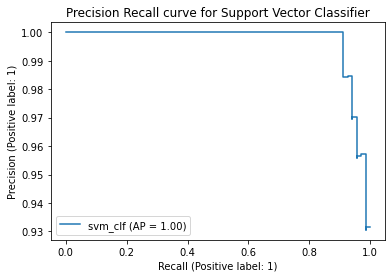

In [32]:
from sklearn.metrics import recall_score, precision_score, PrecisionRecallDisplay

recall_svm_clf = recall_score(y_true=y_test, y_pred=y_pred_svm)
print(f"Recall for support vector classifier: {recall_svm_clf:.3f}")
precision_svm_clf = precision_score(y_true=y_test, y_pred=y_pred_svm)
print(f"Precision for support vector classifier: {precision_svm_clf:.3f}")

display = PrecisionRecallDisplay.from_estimator(
    estimator=svm_clf, X=X_test, y=y_test, name="svm_clf"
)

_=display.ax_.set_title("Precision Recall curve for Support Vector Classifier")


The curve for the support vector classifier must be wrong! - because we have exclusively 0´s and 1´s in y_pred_svm, there is no dependency on the threshold parameter and thus the entire PR-Curve should be the point (0.985, 0.957). <br>
Without looking into the implementation I would guess, that the curve is calculated by choosing a threshold, sub-sampling the test data and doing prediction on this subsample. This would introduce sampling artifacts that show up as the different P and R values for different thresholds.

### Plot the Probability-Mass allocation for each Class ###
Let's have a look at how well the classifier does on each of the two classes, i.e. how much probability for the correct classification of a data-point actually has been allocated to that datapoint.

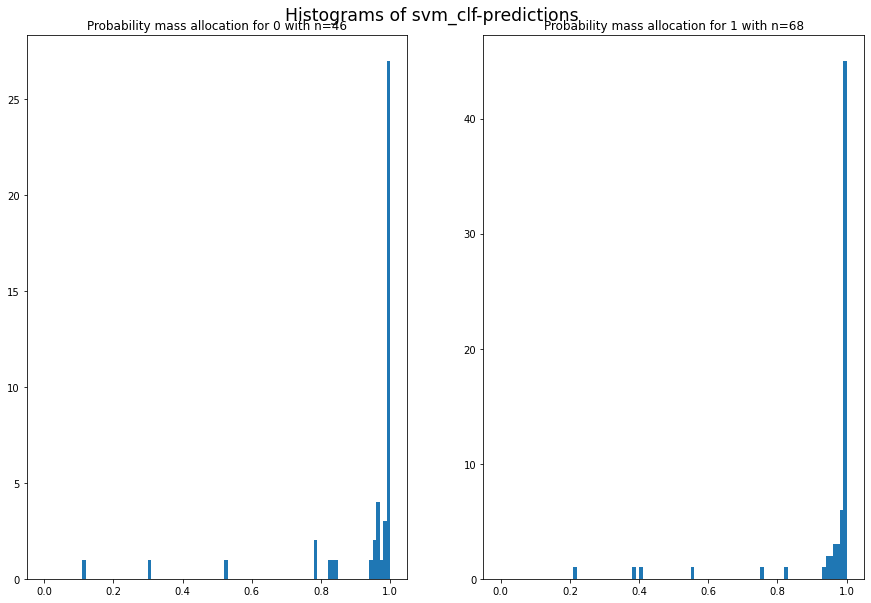

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

#switch = "log_reg"
switch = "svm_clf"

nof_classes = 2 # number of classes/labels
nof_diagram_columns = 2
nof_diagram_rows = 1
fig_width = 15 # drawing-area hight
fig_height = 10 # drawing-area width


fig, axs = plt.subplots(nof_diagram_rows,nof_diagram_columns, figsize=(fig_width,fig_height), sharex=True)
fig.suptitle(f"Histograms of {switch}-predictions", size='xx-large', y=0.92)

stats = np.zeros((nof_classes,2)) # contains the values for mean and var for each class
p_is = []
r = 0
c = 0

for i in range(nof_classes):
    i_mask = y_test == i
    Xi_test = X_test[i_mask] # get the data-point with label i

    if switch == "svm_clf":
        p_i = svm_clf.predict_proba(Xi_test)
    elif switch == "log_reg":
        p_i = log_reg.predict_proba(Xi_test)

    pi_is_i = np.array([ b[i] for b in p_i])
    p_i_sorted = np.sort(pi_is_i)
    p_is.append(p_i_sorted)
    stats[i, 0] = np.mean(pi_is_i)
    stats[i, 1] = np.var(pi_is_i)

    i_counts, i_bins = np.histogram(p_i_sorted, bins=100, range=(0,1))
    if len(axs.shape) > 1:
        axs[r, c].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r, c].set_title(f"Distribution for {i} with n={len(p_is[i])}")

        if c < nof_diagram_columns-1:
            c += 1
        else:
            r += 1
            c = 0
    else:
        axs[r].hist(i_bins[:-1], i_bins, weights=i_counts)
        axs[r].set_title(f"Probability mass allocation for {i} with n={len(p_is[i])}")
        r += 1


#### For log-reg: ####
so we see some of the datapoints of class 0 have gotten quite low probability to be a class 0 - as low as approx. 0.55 and the same goes for the class 1 datapoints, where the spread seems even more pronounced. <br>
Next we calculate the mean allocated probability for each class and the spread (i.e. variance):

In [34]:
for c in [0,1]:
    print(f"Class-{c} has mean allocated probab-mass of {stats[c,0]:.3f} and a variance of this allocation equal to {stats[c, 1]:.3f}")

Class-0 has mean allocated probab-mass of 0.926 and a variance of this allocation equal to 0.031
Class-1 has mean allocated probab-mass of 0.949 and a variance of this allocation equal to 0.022


#### For log-reg: ####
So indeed the classifier does better on class 0 than on class 1 datapoints.